In [158]:
#import sweetviz as sv
import pandas as pd
#import dtale
#import numpy as np
#from sdmetrics.reports.multi_table import QualityReport
%matplotlib inline


import os
import json

from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
#import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import seaborn as sns

#from pycaret.anomaly import *

In [159]:


df_triage = pd.read_csv("..\..\data\Triage.csv",sep=';'  
                    #,parse_dates=['innDatoTid','utDatoTid'], 
  )
df_triage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205488 entries, 0 to 205487
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Phtriage           96061 non-null   float64
 1   Htriage            205487 non-null  float64
 2   Dischgto           205412 non-null  object 
 3   Dischhome          205488 non-null  int64  
 4   DischICU           205488 non-null  int64  
 5   EMRGgroup          205484 non-null  object 
 6   Time_in            205487 non-null  object 
 7   Time_out           205428 non-null  object 
 8   EDLOS              205359 non-null  float64
 9   Kjonn              205480 non-null  object 
 10  InICD10-code       157814 non-null  object 
 11  InICD10-chapter    205488 non-null  object 
 12  Aar                205487 non-null  float64
 13  Mnd                205487 non-null  float64
 14  DOW                205487 non-null  object 
 15  Shift              196066 non-null  object 
 16  np

## Feature enginering

In [160]:
df_triage_t = df_triage.copy()

### Select the variables

In [161]:
features = ['Htriage' , 
           #   'Dischgto'
             'Dischhome', 
            'DischICU', 
            'EMRGgroup',
        'Kjonn', 'InICD10-chapter',
          #  'Aar' correlated to triagestmt
            'Mnd'
       ,'DOW', 'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
            'AgeGrp',
            '24hmrt',
      # '7dmrt', 30dmrt,
            'Triagestm', 
            'Time_in_h'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]
categorical_features =[ 'Htriage'
                       # 'Dischgto'
                       , 'Dischhome'#, 'DischICU'
                        'EMRGgroup',
        'Kjonn',  'InICD10-chapter',
                 #      'Aar'
                        'Mnd',
       'DOW', 'Shift',# 'nprDiagn',# 'Out_ICD10-chapter',
                       'AgeGrp',
                       '24hmrt',
      # '7dmrt',
       '30dmrt',
                       'Triagestm',
     # 'Time_in_h'#, 'Time_in_m', 
       #'Time_out_h', 'Time_out_m'
                      ]

nominal_features=[#'Dischgto', 
                  #'Dischhome'#, 'DischICU'
                  'EMRGgroup',
        'Kjonn',  'InICD10-chapter',
       'DOW', 'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
    '24hmrt'
     #  ,'7dmrt', '30dmrt'
]
ordinal_features=[ 'Htriage', 
          #        'Aar'
                   'Mnd',
      'Age', 'Triagestm',
     # 'Time_in_h'#, 'Time_in_m', 
       #'Time_out_h', 'Time_out_m'
                 ]


## Imputation

In [162]:
from sklearn.impute import SimpleImputer
import numpy as np
# Setting the random_state argument for reproducibility

imputer = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='missing')
#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
#imputer = imp_constant(random_state=42)
imputer.fit(df_triage_t[nominal_features])
df_triage_t[nominal_features] = imputer.transform(pd.DataFrame(df_triage_t, columns=nominal_features))

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(df_triage_t[ordinal_features])
df_triage_t[ordinal_features] = imputer.transform(pd.DataFrame(df_triage_t, columns=ordinal_features))





### Select population of undertriaged/overtriaged patients

In [163]:
#Number of undertriaged patients 30d alive
#df_triage_t = df_triage_t.loc[(df_triage_t['30dmrt']==1) & (df_triage_t.DischICU==1)]

## Undertriage
df_triage_t = df_triage_t.loc[df_triage_t.Mrt_AND_OR_ICU==1]

## Ovrtriage
#df_triage_t = df_triage_t.loc[df_triage_t.Dischhome==1]

df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9784 entries, 35 to 205185
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Phtriage           5238 non-null   float64
 1   Htriage            9784 non-null   float64
 2   Dischgto           9784 non-null   object 
 3   Dischhome          9784 non-null   int64  
 4   DischICU           9784 non-null   int64  
 5   EMRGgroup          9784 non-null   object 
 6   Time_in            9784 non-null   object 
 7   Time_out           9783 non-null   object 
 8   EDLOS              9773 non-null   float64
 9   Kjonn              9784 non-null   object 
 10  InICD10-code       8177 non-null   object 
 11  InICD10-chapter    9784 non-null   object 
 12  Aar                9784 non-null   float64
 13  Mnd                9784 non-null   float64
 14  DOW                9784 non-null   object 
 15  Shift              9784 non-null   object 
 16  nprDiagn           93

## Transform Features

### Emergency Group


<AxesSubplot:>

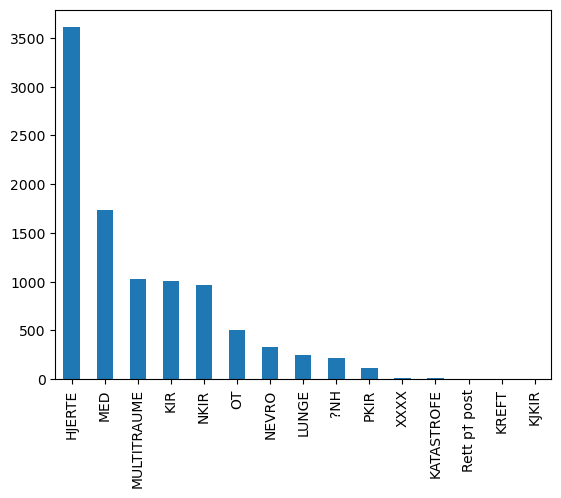

In [164]:
df_triage_t["EMRGgroup"].value_counts().plot(kind='bar')

In [165]:
emr_map= {'HJERTE'          :'Cardiology',
'MED'             :'Medical',
'MULTITRAUME'     :'Trauma',
'KIR'             :'Surgery',
'NKIR'             : 'Neurosurger' ,
'OT'               : 'Orthopedics',
 'ORT': 'Orthopedics',
'NEVRO'            :'Neurology',
'LUNGE'           : 'Medical',
'?NH'              :'Otolaryngology',
 'ØNH'              :'Otolaryngology',
'PKIR'             :'Plastic surgery',
'XXXX'              :'NA',
'KATASTROFE'         :'Other',
'Rett p† post'       :'Other',
'KREFT'              :'Oncology',
'KJKIR':'Surgery'     }

<AxesSubplot:>

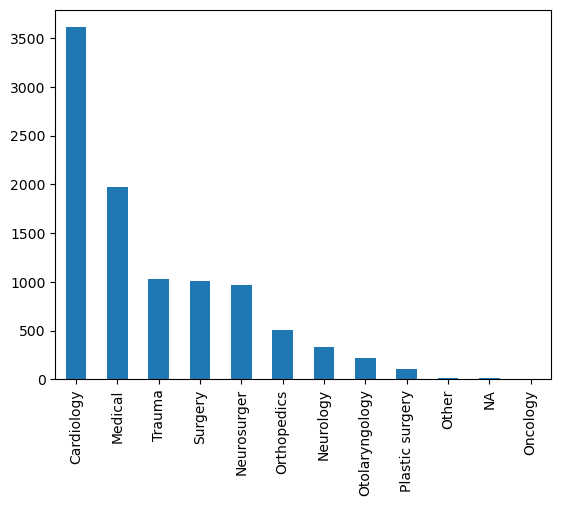

In [166]:

df_triage_t["EMRGgroup"] = df_triage_t.EMRGgroup.map(emr_map)
df_triage_t["EMRGgroup"].value_counts().plot(kind='bar')

###  Age

<AxesSubplot:>

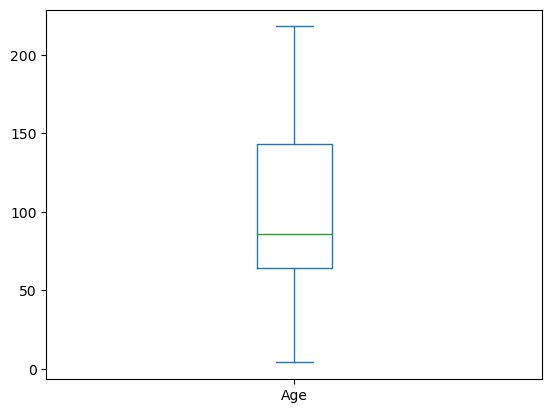

In [167]:
df_triage_t['Age'].value_counts().plot(kind='box')

<AxesSubplot:>

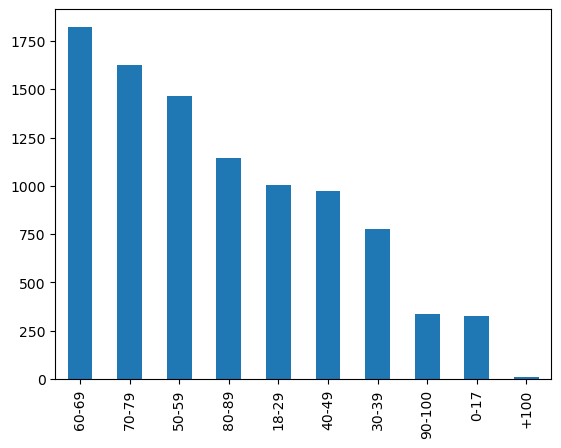

In [168]:
df_triage_t.Age= df_triage_t.Age.astype(float).astype(int)
#df_triage_t=df_triage_t.loc[df_triage_t.Age>=18]
bins = [10,18,30,40,50,60,70,80,90,100,200]
labels = ['0-17','18-29', '30-39','40-49','50-59','60-69','70-79','80-89','90-100','+100']
df_triage_t['AgeGrp'] = pd.cut(df_triage_t.Age, bins, labels = labels,right=False)
#df_triage_t["AgeGrp"] = df_triage_t.AgeGrp.map({'0-12':0,'13-17':1, '20-64':2, '65+':3})
#df_triage_t["AgeGrpDesc"] = df_triage_t.AgeGrp.map({'0-12':'Children','13-17':'Teen', '18-64':'Adult', '65+':'Older'})
df_triage_t['AgeGrp'].value_counts().plot(kind='bar')

### Triage score 

<AxesSubplot:>

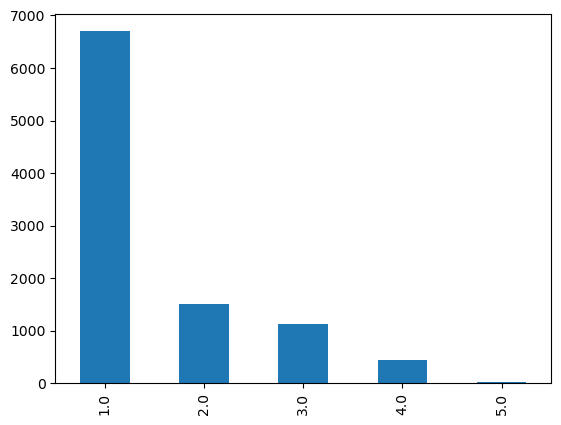

In [169]:
df_triage_t['Htriage'].value_counts().plot(kind='bar')

<AxesSubplot:>

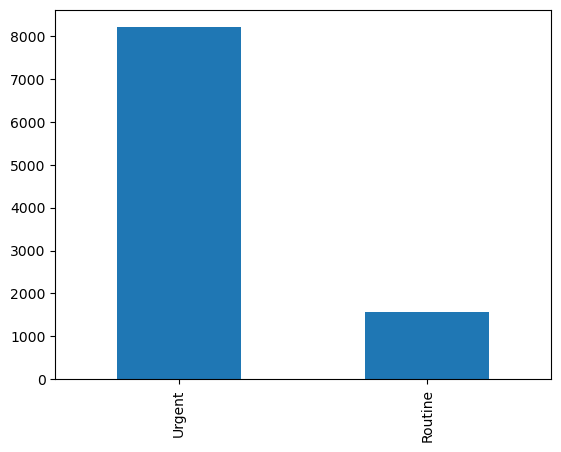

In [170]:
df_triage_t['Htriage']= df_triage_t['Htriage'].astype(float).astype(int)
df_triage_t['HtriageGrp'] = np.where(df_triage_t['Htriage']<3,0,1)
df_triage_t['HtriageGrpDesc'] = np.where(df_triage_t['Htriage']<3,"Urgent","Routine")
df_triage_t['HtriageGrpDesc'].value_counts().plot(kind='bar')

###  Shift

<AxesSubplot:>

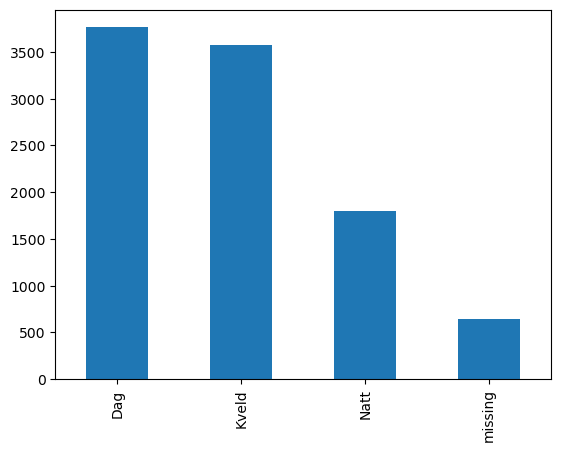

In [171]:
df_triage_t["Shift"].value_counts().plot(kind='bar')

<AxesSubplot:>

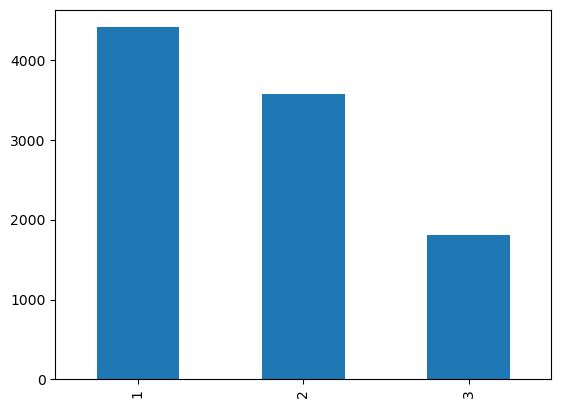

In [172]:

df_triage_t["Shift"] = df_triage_t.Shift.map({'Dag':1,'Kveld':2,'Natt':3,'missing':1})
df_triage_t["Shift"].value_counts().plot(kind='bar')

### Transform Mnd

<AxesSubplot:>

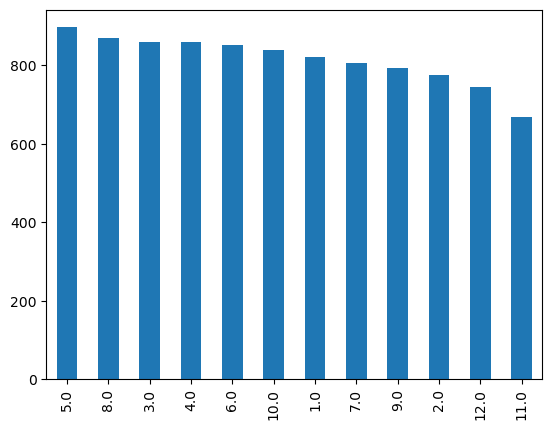

In [173]:
df_triage_t["Mnd"].value_counts().plot(kind='bar')

<AxesSubplot:>

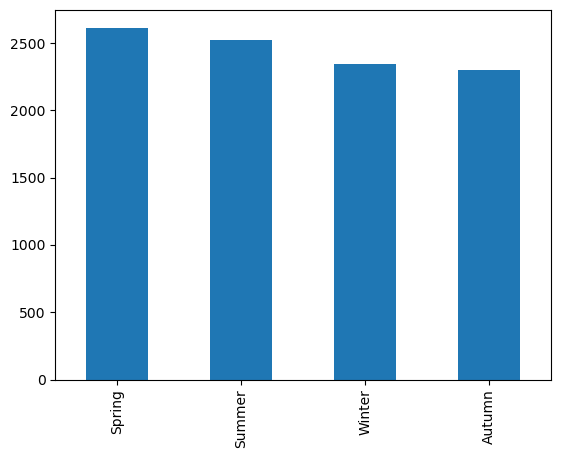

In [174]:
season_month_north = {
            12.0:'Winter', 1.0:'Winter', 2.0:'Winter',
            3.0:'Spring', 4.0:'Spring', 5.0:'Spring',
            6-0:'Summer', 7.0:'Summer', 8.0:'Summer',
            9.0:'Autumn', 10.0:'Autumn', 11.0:'Autumn'}
df_triage_t["Season"] = df_triage_t.Mnd.map(season_month_north)
df_triage_t["Season"].value_counts().plot(kind='bar')

### Admission Time

In [175]:


df_triage_t.Time_in= pd.to_datetime(df_triage_t.Time_in)
#df_triage_t.Time_out= pd.to_datetime(df_triage_t.Time_out)

In [176]:

df_triage_t['Time_in_h']=df_triage_t.Time_in.dt.strftime('%H')


In [177]:
for c in df_triage_t.select_dtypes(include='object'):
    df_triage_t[c] = df_triage_t[c].astype('string')
#df_triage_t[categorical_features].info()
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9784 entries, 35 to 205185
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Phtriage           5238 non-null   float64       
 1   Htriage            9784 non-null   int32         
 2   Dischgto           9784 non-null   string        
 3   Dischhome          9784 non-null   int64         
 4   DischICU           9784 non-null   int64         
 5   EMRGgroup          9784 non-null   string        
 6   Time_in            9784 non-null   datetime64[ns]
 7   Time_out           9783 non-null   string        
 8   EDLOS              9773 non-null   float64       
 9   Kjonn              9784 non-null   string        
 10  InICD10-code       8177 non-null   string        
 11  InICD10-chapter    9784 non-null   string        
 12  Aar                9784 non-null   float64       
 13  Mnd                9784 non-null   float64       
 14  DOW  

<AxesSubplot:>

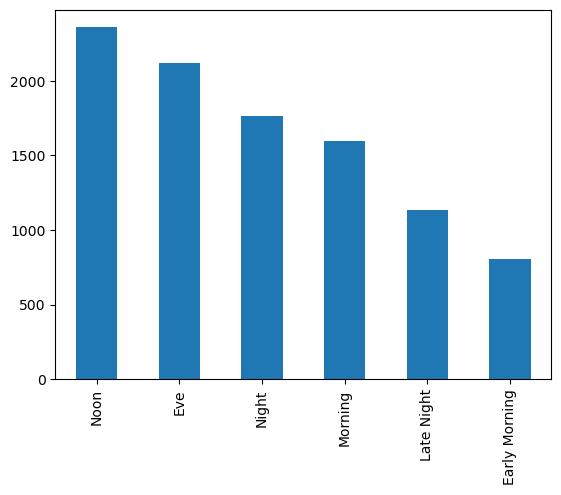

In [178]:
df_triage_t['Admtime']= df_triage_t.Time_in_h.astype(float).astype(int)
#df_triage_t=df_triage_t.loc[df_triage_t.Age>=18]
bins =  [0,4,8,12,16,20,24]
labels = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df_triage_t['AdmtimeGrp'] = pd.cut(df_triage_t.Admtime, bins, labels = labels,right=False)
#df_triage_t["AgeGrp"] = df_triage_t.AgeGrp.map({'0-12':0,'13-17':1, '20-64':2, '65+':3})
#df_triage_t["AgeGrpDesc"] = df_triage_t.AgeGrp.map({'0-12':'Children','13-17':'Teen', '18-64':'Adult', '65+':'Older'})                                                  
df_triage_t['AdmtimeGrp'].value_counts().plot(kind='bar')

## Classification and SHAP values

In [179]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

import shap
shap.initjs()

In [180]:
features = ['HtriageGrp' , 
             # 'Dischgto'
            # 'Dischhome', 
            #'DischICU', 
            'EMRGgroup',
        'Kjonn'#, 'InICD10-chapter',
          #  'Aar' correlated to triagestmt
        #    'Mnd',
    #'Season',
      # 'DOW', #'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
         ,   'AgeGrp',
          #  '24hmrt',
      # '7dmrt', '30dmrt',
        #    'Triagestm', 
           'AdmtimeGrp'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]
nominal_features=[#'Dischgto', 
                  #'Dischhome'#, 'DischICU'
                  'EMRGgroup','AdmtimeGrp'
        'Kjonn'#,  'InICD10-chapter',
     #  'DOW', # 'nprDiagn', 'Out_ICD10-chapter',
    '24hmrt'#,'Season'
     #  ,'7dmrt', '30dmrt'
]
ordinal_features=[ #'HtriageGrp', 
          #        'Aar'
                   #'Mnd',
      'AgeGrp', #'Time_in_h'# 'Time_in_h'#'Triagestm'
     # 'Shift'#, 'Time_in_m', 
       #'Time_out_h', 'Time_out_m'
                 ]

In [181]:
data = df_triage_t[features]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9784 entries, 35 to 205185
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   HtriageGrp  9784 non-null   int32   
 1   EMRGgroup   9784 non-null   string  
 2   Kjonn       9784 non-null   string  
 3   AgeGrp      9483 non-null   category
 4   AdmtimeGrp  9784 non-null   category
dtypes: category(2), int32(1), string(2)
memory usage: 287.2 KB


In [182]:
#load data 
data = df_triage_t[features]

#get features
y = data['HtriageGrp']
y = y.astype('category').cat.codes
X_cat = data.drop('HtriageGrp', axis=1)

In [183]:
#fit encoder
enc = OneHotEncoder()
enc.fit(X_cat)

#transform categorical features
X_encoded = enc.transform(X_cat).toarray()

#create feature matrix
feature_names = X_cat.columns
new_feature_names = enc.get_feature_names_out(feature_names)

X = pd.DataFrame(X_encoded, columns= new_feature_names)

In [184]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y
)
#class_weight=int(y.value_counts()[0]/y.value_counts()[1])

In [185]:

#Train model
model = xgb.XGBClassifier(objective="binary:logistic",  
                         max_depth=2, 
                         n_estimators=10)
#model =  RandomForestClassifier(random_state=42,class_weight="balanced")
model.fit(X, y,sample_weight=classes_weights)
#model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### Standard SHAP values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


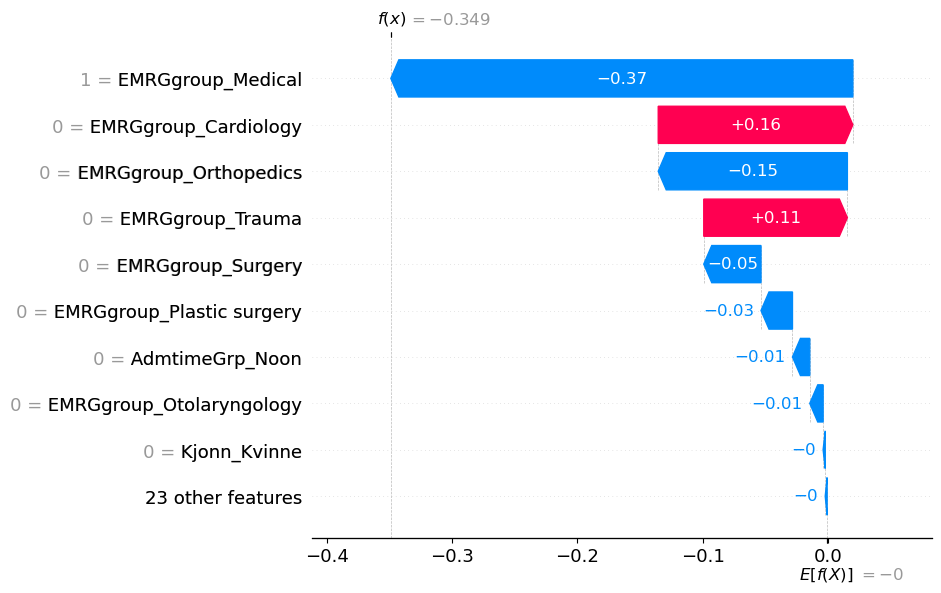

In [186]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# waterfall plot for first observation
shap.plots.waterfall(shap_values[300])

### SHAP for categorical features

In [187]:

print(shap_values)

.values =
array([[ 1.5555426e-01, -3.6927614e-01,  0.0000000e+00, ...,
         0.0000000e+00,  2.9141575e-04, -1.3835855e-02],
       [ 1.8840045e-01,  8.1427753e-02,  0.0000000e+00, ...,
         0.0000000e+00,  2.9141575e-04, -2.1302672e-03],
       [ 1.5555426e-01, -3.6927614e-01,  0.0000000e+00, ...,
         0.0000000e+00,  2.9141575e-04, -1.3835855e-02],
       ...,
       [ 1.5555426e-01, -3.6927614e-01,  0.0000000e+00, ...,
         0.0000000e+00,  2.9141575e-04, -1.3835855e-02],
       [ 1.5555426e-01, -3.6927614e-01,  0.0000000e+00, ...,
         0.0000000e+00,  2.9141575e-04, -1.3835855e-02],
       [-3.2895407e-01,  5.7473183e-02,  0.0000000e+00, ...,
         0.0000000e+00,  2.9141575e-04,  7.3042158e-03]], dtype=float32)

.base_values =
array([-0.00043075, -0.00043075, -0.00043075, ..., -0.00043075,
       -0.00043075, -0.00043075], dtype=float32)

.data =
array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
  

In [188]:
print(shap_values.values[0])

[ 1.55554265e-01 -3.69276136e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.51174828e-01  0.00000000e+00
 -2.27115117e-03 -2.51455978e-02 -4.57533561e-02  1.01961724e-01
 -1.67990662e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.75797972e-03  0.00000000e+00
  0.00000000e+00 -1.42657338e-03  0.00000000e+00  0.00000000e+00
  2.91961769e-04  0.00000000e+00  2.91415752e-04 -1.38358548e-02]


add the SHAP values for each categorical feature together.

In [189]:
#get number of unique categories for each feature 
n_categories = []
for feat in feature_names[:-1]:
    n = X_cat[feat].nunique()
    n_categories.append(n)

In [190]:
new_shap_values = []
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    new_shap_values.append(values_sum)

In [191]:
#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
new_data = np.array(X_cat)
shap_values.data = np.array(new_data)

#update feature names
shap_values.feature_names = list(X_cat.columns)

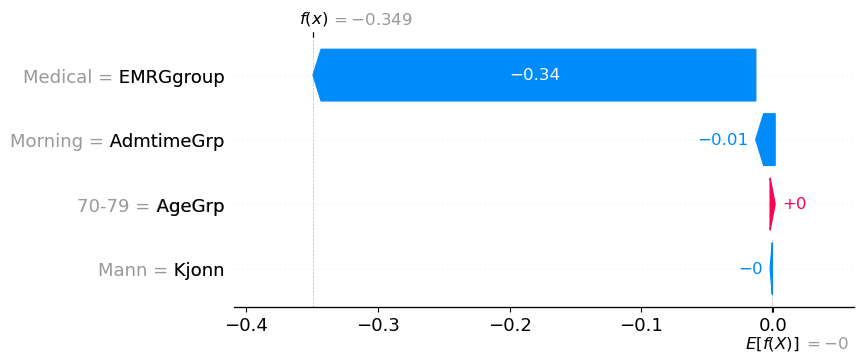

In [192]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

the InICD10-Chapter A And lack of other Diagnoses has increased the log odds
the EMRGgroup MED A And lack of other Diagnoses has increased the log odds

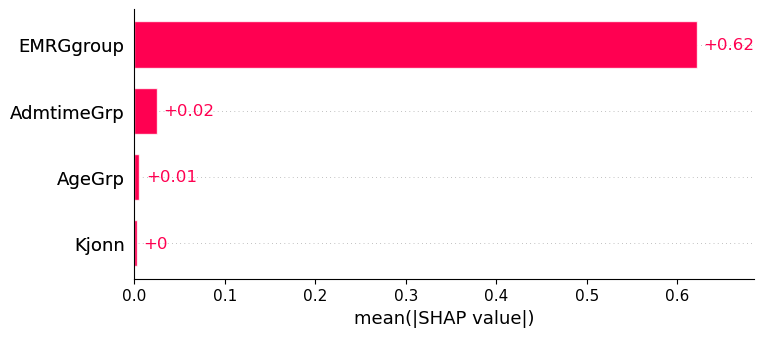

In [193]:
#Mean SHAP
shap.plots.bar(shap_values)

Text(0.5, 0, 'Emergency_Group')

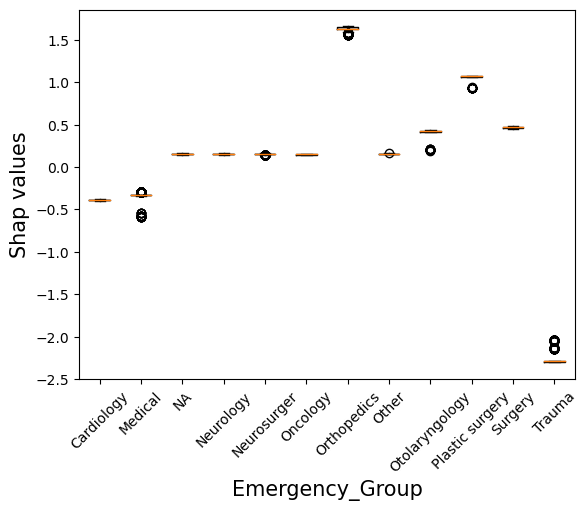

In [194]:
#split EMRGgroup shap values based on  individual EMRGgroup values

emrg_values = shap_values[:,"EMRGgroup"].values
emrg_data = shap_values[:,"EMRGgroup"].data
emrg_categories = sorted(list(set(emrg_data)), key=str.lower)

emrg_groups = []
for o in emrg_categories:
    relevant_values = emrg_values[emrg_data == o]
    emrg_groups.append(relevant_values)
    
#replace categories with labels

              
Emrg_labels = {'AKUTTPOL':'Emergency Pol',
               ' KRISE':'Disaster', 
               'KATASTROFE':'Disaster', 
               'MED':'MED', 
               'GYN':'Gynocolog',
               '?NH':'Otolaryngologi', 
               'ØNH':'Otolaryngologi', 
                'LAB':'LAB',
               'KIR':'Chirurgy', 
               'ORT':'Ortopedy', 
               'OT':'Ortopedy', 
               'NEVRO':'Neurological', 
               'MED':'Medical', 
               'KREFT':'Cancer',
               'Rett p† post':'To ward',
               'MULTITRAUME':'Multi-trauma',
               'KJKIR':'K chirurgy',
               'NKIR':'N chirurgy',
               'PKIR':'P chirurgy',
               'XXXX':'Missing',
               'INFO':'INFO',
               'ANNET':'OTHER',
               'HUD':'Skin',
               'ØYE':'Eyes',
               'AP NEVROKIR':'Neurochirurgie',
               'LUNGE':'Lungs',
               'HJERTE':'Cardio'
               
              
              
              
              
              
              }

labels =emrg_categories
#labels= [Emrg_labels[u] for u in emrg_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)

plt.boxplot(emrg_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Emergency_Group',size=15)

Text(0.5, 0, 'AgeGroup')

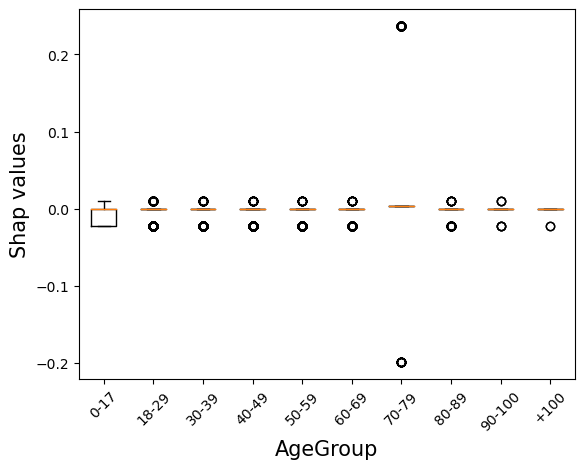

In [196]:
#split AgeGrp shap values based on  individual AgeGrp values

age_values = shap_values[:,"AgeGrp"].values
age_data = shap_values[:,"AgeGrp"].data
age_categories = list(set(age_data))
#print(age_categories)
age_categories = ['0-17','18-29', '30-39', '40-49', '50-59', '60-69', '70-79','80-89','90-100','+100']
age_groups = []
for o in age_categories:
    relevant_values = age_values[age_data == o]
 
    age_groups.append(relevant_values)


labels = age_categories
#labels= [ageGrp_labels[u] for u in ageGrp_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)

plt.boxplot(age_groups,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)  

#plt.boxplot(ageGrp_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('AgeGroup',size=15)

Text(0.5, 0, 'AdmtimeGrp')

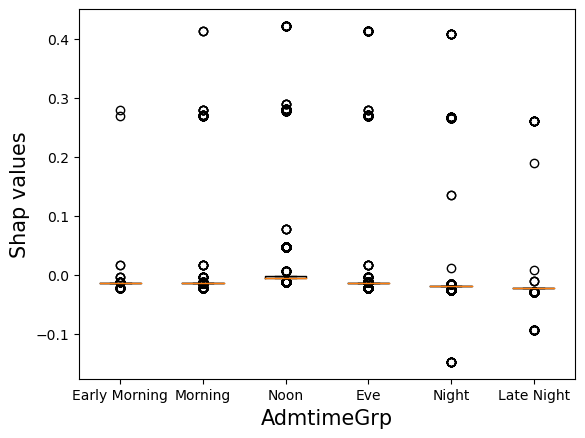

In [199]:
#split AdmtimeGrp shap values based on  individual AdmtimeGrp values

timeinH_values = shap_values[:,"AdmtimeGrp"].values
timeinH_data = shap_values[:,"AdmtimeGrp"].data
#timeinH_categories = list(set(timeinH_data))

timeinH_groups = []
timeinH_categories=['Early Morning','Morning', 'Noon',   'Eve','Night', 'Late Night']
for o in timeinH_categories:
    relevant_values = timeinH_values[timeinH_data == o]
    timeinH_groups.append(relevant_values)
    
#replace categories with labels


labels = timeinH_categories
#labels= [timeinH_labels[u] for u in timeinH_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))

plt.boxplot(timeinH_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('AdmtimeGrp',size=15)

Text(0.5, 0, 'Sex')

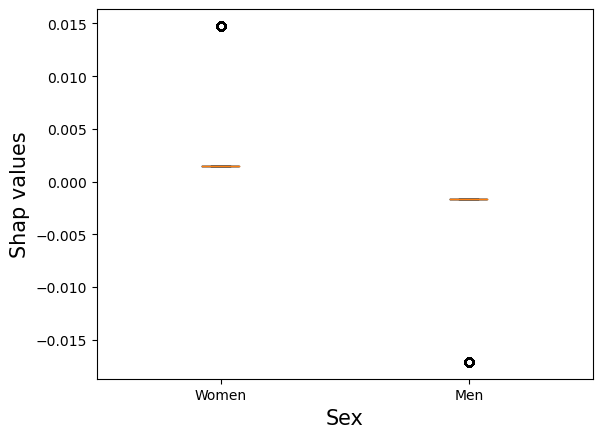

In [200]:
#split Sex shap values based on  individual Sex values

Kjonn_values = shap_values[:,"Kjonn"].values
Kjonn_data = shap_values[:,"Kjonn"].data
Kjonn_categories = ['Kvinne','Mann']#list(set(Kjonn_data))

Kjonn_groups = []
for o in Kjonn_categories:
    relevant_values = Kjonn_values[Kjonn_data == o]
    Kjonn_groups.append(relevant_values)
    
#replace categories with labels
Kjonn_labels = {'Kvinne':'Women',
                'Mann':'Men',
                'missing':'Missing'
               
              
              
              
              
              
              }

labels = Kjonn_categories
labels= [Kjonn_labels[u] for u in Kjonn_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))

plt.boxplot(Kjonn_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Sex',size=15)